## Preparing binary classifier

Let's try to create and train classifier to identify GALAXIES.

In [76]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.svm import SVC
import random
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import time

In [2]:
from sklearn.model_selection import StratifiedShuffleSplit
def get_train_test():
    # load
    df = pd.read_csv("star_classification.csv")
    # remove outliers
    # select the row with u or z or g below 0 (should not be allowed)
    outliers = df[(df["u"] <= 0)  
                | (df["z"] <= 0) 
                | (df["g"] <= 0)
                | (df["redshift"] <= 0)]

    # drop the row corresponding to the outlier
    df = df.drop(outliers.index, axis=0)
    # we drop the data we are not interested in and which won't be useful
    df = df.drop(
        columns=["obj_ID", "fiber_ID", "MJD", "plate", "spec_obj_ID", 
                 "field_ID", "cam_col", "rerun_ID", "run_ID"], axis=1)
    
    # stratified split
    split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    
    for train_index, test_index in split.split(df, df["class"]):
        strat_train_set = df.loc[train_index]
        strat_test_set = df.loc[test_index]
        
    return strat_train_set, strat_test_set

In [173]:
train, test = get_train_test()
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

# seperate measurements (x) with class(y)
x_train = train.drop(columns=["class"], axis=1)
y_train = train["class"]

# replace all infinite values with NaN
x_train = x_train.replace([np.inf, -np.inf], np.nan)
y_train = y_train.replace([np.inf, -np.inf], np.nan)

# drop all the rows with NaN
x_train = x_train.dropna(axis=0)
y_train = y_train.dropna(axis=0)

# seperate measurements (x) with class(y)
x_test = test.drop(columns=["class"], axis=1)
y_test = test["class"]

# replace all infinite values with NaN
x_test = x_test.replace([np.inf, -np.inf], np.nan)
y_test = y_test.replace([np.inf, -np.inf], np.nan)

# drop all the rows with NaN
x_test = x_test.dropna(axis=0)
y_test = y_test.dropna(axis=0)

x_train = x_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

# array of true/false to find galaxies 
y_train_galaxy = (y_train == "GALAXY")
y_test_galaxy = (y_test == "GALAXY")

In [4]:
x_train = StandardScaler().fit_transform(x_train)
x_test = StandardScaler().fit_transform(x_test)

## Confusion matrix with star binary classifier

we're not using the test set, we will use the cross_val_predict function (cross_val_predict() performs K-fold cross-validation, but instead of returning the evaluation scores, it returns the predictions made on each test fold)

**Confusion matrix**
- each column = predicted class
- each row = actual class

Calculating:
1. Precision:
$$precision = \frac{TP}{TP+FP}$$
2. Recall:
$$recall = \frac{TP}{TP+FN}$$
3. F1 score:
$$F1 = \frac{2}{\frac{1}{precision} + \frac{1}{recall}}$$

## Trying new classifier: SGD

In [5]:
sgd_clf = SGDClassifier(random_state=42)
# cross validation
y_train_pred = cross_val_predict(sgd_clf, x_train, y_train_galaxy, cv=3)

# confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_galaxy, y_train_pred)

array([[13130,  5648],
       [ 1766, 38378]], dtype=int64)

In [6]:
print("F1 score of the model", f1_score(y_train_galaxy, y_train_pred))

F1 score of the model 0.9119163597481289


We will try to fine-tune the model: vary the threshold of the decision function to optimise the F1 score of our binary model.

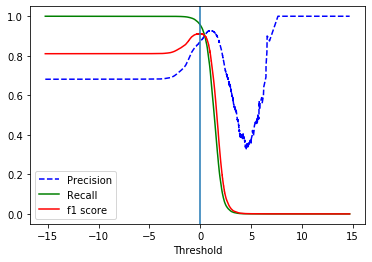

In [7]:
# why cross validation here?
y_scores_SGD = cross_val_predict(SGDClassifier(random_state=42), x_train, y_train_galaxy, cv=3, 
                                 method="decision_function")

precisions, recalls, thresholds = precision_recall_curve(y_train_galaxy, y_scores_SGD)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    f1_score = 2/(1/precisions[:-1] + 1/recalls[:-1])
    plt.plot(thresholds, f1_score, "r-", label="f1 score")
    plt.axvline(x = 0)
    #plt.xlim(thresholds.min(), thresholds.max())
    plt.legend()
    plt.xlabel("Threshold")
    # highlight the threshold and add the legend, axis label, and grid

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [8]:
f1_score_array = 2/(1/precisions[:-1] + 1/recalls[:-1])
max_f1 = np.max(f1_score_array)
max_f1_threshold = thresholds[np.argmax(f1_score_array)]
print("The maximum f1 score is:", max_f1, "which happens at a threshold of:", max_f1_threshold)

The maximum f1 score is: 0.912109075012701 which happens at a threshold of: -0.07318990928952807


In [9]:
# only take scores above threshold to be True
y_train_pred_new = (y_scores_SGD > max_f1_threshold)
    
print(confusion_matrix(y_train_galaxy, y_train_pred_new))

print("Precision of the model:", precision_score(y_train_galaxy, y_train_pred_new))
print("Recall of the model:", recall_score(y_train_galaxy, y_train_pred_new))
print("Accuracy of the model:", accuracy_score(y_train_galaxy, y_train_pred_new))
print("F1 score of the model", f1_score(y_train_galaxy, y_train_pred_new))

[[12883  5895]
 [ 1545 38599]]
Precision of the model: 0.8675102260979008
Recall of the model: 0.9615135512156238
Accuracy of the model: 0.873731373680459
F1 score of the model 0.9120962215553298


## Trying new classifier: Random Forest


In [10]:
forest_clf = RandomForestClassifier(random_state=42)
y_probas_RF = cross_val_predict(forest_clf, x_train, y_train_galaxy, cv=3,
                                    method="predict_proba")
y_scores_RF = y_probas_RF[:, 1]   # score = proba of positive class

## Trying new classifier: Nearest Neighbours

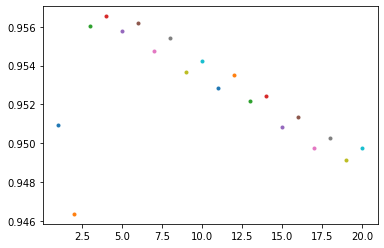

In [11]:
neighbours = range(1,21)
for n in neighbours:
    neigh = KNeighborsClassifier(n_neighbors=n)
    y_train_pred_neigh = cross_val_predict(neigh, x_train, y_train_galaxy, cv=3)
    plt.plot(n, f1_score(y_train_galaxy, y_train_pred_neigh), '.');

In [68]:
start_time = time.time()
neigh = KNeighborsClassifier(n_neighbors=4)
# we'll be using k=4 later on which is why we define it as y_scores_KNN
y_scores_KNN = cross_val_predict(neigh, x_train, y_train_galaxy, cv=3)
print("--- %s seconds ---" % (time.time() - start_time))
print("f1 score:", f1_score(y_train_galaxy, y_scores_KNN))

--- 5.817574501037598 seconds ---
f1 score: 0.9565422650698207


## Trying new classifier: Decision Tree

In [17]:
DT_clf = DecisionTreeClassifier(random_state=42)
y_scores_DT = cross_val_predict(DT_clf, x_train, y_train_galaxy, cv=3)

## Trying new classifier: Linear SVC

In [18]:
linsvc_clf = LinearSVC(random_state=42)
y_scores_LinSVC = cross_val_predict(linsvc_clf, x_train, y_train_galaxy, cv=3)

C:\Users\ellio\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\ellio\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\ellio\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


## Comparing SGD, KNN, RF, DT, SVM with ROC curves

In [19]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("FPR")
    plt.ylabel("TPR = Recall")

In [20]:
# tpr and fpr for various threshold values
fpr_SGD, tpr_SGD, thresholds_SGD = roc_curve(y_train_galaxy, y_scores_SGD)
fpr_RF, tpr_RF, thresholds_RF = roc_curve(y_train_galaxy,y_scores_RF)
fpr_KNN, tpr_KNN, thresholds_KNN = roc_curve(y_train_galaxy,y_scores_KNN)
fpr_DT, tpr_DT, thresholds_DT = roc_curve(y_train_galaxy,y_scores_DT)
fpr_LinSVC, tpr_LinSVC, thresholds_LinSVC = roc_curve(y_train_galaxy,y_scores_LinSVC)

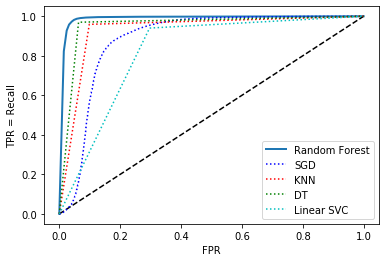

Area under the curve of (SGD classifier): 0.8836508796790389
Area under the curve of (RF classifier): 0.9871038437522248
Area under the curve of (KNN classifier): 0.930199950165558
Area under the curve of (DT classifier): 0.9532466722950005
Area under the curve of (LinSVC classifier): 0.8217583928128203


In [32]:
plot_roc_curve(fpr_RF, tpr_RF, "Random Forest")
plt.plot(fpr_SGD, tpr_SGD, "b:", label="SGD")
plt.plot(fpr_KNN, tpr_KNN, "r:", label="KNN")
plt.plot(fpr_DT, tpr_DT, "g:", label="DT")
plt.plot(fpr_LinSVC, tpr_LinSVC, "c:", label="Linear SVC")

plt.legend(loc="lower right")
plt.show()

# Can also measure the area under the curve AUC
from sklearn.metrics import roc_auc_score
print("Area under the curve of (SGD classifier):", roc_auc_score(y_train_galaxy, y_scores_SGD))
print("Area under the curve of (RF classifier):", roc_auc_score(y_train_galaxy, y_scores_RF))
print("Area under the curve of (KNN classifier):", roc_auc_score(y_train_galaxy, y_scores_KNN))
print("Area under the curve of (DT classifier):", roc_auc_score(y_train_galaxy, y_scores_DT))
print("Area under the curve of (LinSVC classifier):", roc_auc_score(y_train_galaxy, y_scores_LinSVC))

### Testing the models on testing set using f1 score

In [74]:
# Random Forest on test set
forest_clf = RandomForestClassifier(random_state=42)
forest_clf.fit(x_train, y_train_galaxy)
y_test_pred = forest_clf.predict(x_test)
print("F1 score of random forest:", f1_score(y_test_galaxy, y_test_pred))
# KNN on test set
neigh = KNeighborsClassifier(n_neighbors=4)
neigh.fit(x_train, y_train_galaxy)
y_test_pred = neigh.predict(x_test)
print("F1 score of KNN:", f1_score(y_test_galaxy, y_test_pred))
# Decision Tree on test set
DT_clf = DecisionTreeClassifier(random_state=42)
DT_clf.fit(x_train, y_train_galaxy)
y_test_pred = DT_clf.predict(x_test)
print("F1 score of decision tree:", f1_score(y_test_galaxy, y_test_pred))
# Linear SVC on test set
linsvc_clf = LinearSVC(random_state=42)
linsvc_clf.fit(x_train, y_train_galaxy)
y_test_pred = linsvc_clf.predict(x_test)
print("F1 score of Linear SVC:", f1_score(y_test_galaxy, y_test_pred))
# SGD on test set
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(x_train, y_train_galaxy)
y_test_pred = sgd_clf.predict(x_test)
print("F1 score of SGD:", f1_score(y_test_galaxy, y_test_pred))

F1 score of random forest: 0.9785932721712538
F1 score of KNN: 0.958898702323975
F1 score of decision tree: 0.9697298898819812


C:\Users\ellio\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


F1 score of Linear SVC: 0.9052060531074522
F1 score of SGD: 0.9146162233916465


## Fine tuning classifiers and optimising hyperparameters

Random forest hyperparameters: https://medium.com/analytics-vidhya/random-forest-classifier-and-its-hyperparameters-8467bec755f6

We select the best three models: 1. Random Forest, 2. Decision Tree, 3. K-Nearest Neighbours.

### 1. Random Forest

In [44]:
param_grid = {'n_estimators': np.linspace(1,200,200).astype(int), 
               'max_features': np.linspace(1,5,5).astype(int),
               #'criterion': ['mse', 'mae'],
               'min_samples_split': np.linspace(2,100,99).astype(int),
               'min_samples_leaf': np.linspace(1,100,100).astype(int),
               'min_weight_fraction_leaf': [0, 0.1, 0.2, 0.3, 0.4]}

forest_clf = RandomForestClassifier(random_state=42)

number_iterations = [10, 20, 30]
time_taken = []
f1_score_RF = []

for n in number_iterations: 
    random_search_RF = RandomizedSearchCV(forest_clf, param_distributions=param_grid, cv = 3, n_iter = n)
    random_search_RF.fit(x_train, y_train_galaxy)
    print(random_search_RF.best_params_)
    print("Time taken for random search with", n, " iterations: ", time.time() - start_time)

{'n_estimators': 47, 'min_weight_fraction_leaf': 0, 'min_samples_split': 73, 'min_samples_leaf': 75, 'max_features': 4}
Time taken for random search with 10  iterations:  96.53729891777039
{'n_estimators': 18, 'min_weight_fraction_leaf': 0, 'min_samples_split': 72, 'min_samples_leaf': 14, 'max_features': 5}
Time taken for random search with 20  iterations:  251.85934162139893
{'n_estimators': 189, 'min_weight_fraction_leaf': 0, 'min_samples_split': 65, 'min_samples_leaf': 24, 'max_features': 3}
Time taken for random search with 30  iterations:  692.2833395004272


In [45]:
param_grid = {'n_estimators': [25, 50], 
               'max_features': [2,3],
               #'criterion': ['mse', 'mae'],
               'min_samples_split': [70],
               'min_samples_leaf': [20, 50],
               'min_weight_fraction_leaf': [0]}

forest_clf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(forest_clf, param_grid, cv=3)

grid_search.fit(x_train, y_train_galaxy)

grid_search.best_params_

{'max_features': 3,
 'min_samples_leaf': 20,
 'min_samples_split': 70,
 'min_weight_fraction_leaf': 0,
 'n_estimators': 25}

In [60]:
number_esti = [10, 20, 30, 40, 50, 75, 100, 125, 150, 200]
time_taken = []
roc_auc_score_RF = []

for n in number_esti:    
    start_time = time.time()
    forest_clf = RandomForestClassifier(n_estimators=n, min_samples_split=70, min_samples_leaf=20,
                                    min_weight_fraction_leaf=0, max_features=3, random_state=42)
    y_probas_RF = cross_val_predict(forest_clf, x_train, y_train_galaxy, cv=3,
                                    method="predict_proba")
    y_scores_RF = y_probas_RF[:, 1]
    time_taken = np.append(time_taken, time.time() - start_time)
    roc_auc_score_RF = np.append(roc_auc_score_RF, roc_auc_score(y_train_galaxy, y_scores_RF))
    print("Time taken fitting of", n, " estimators: ", time.time() - start_time)

Time taken fitting of 10  estimators:  4.3667378425598145
Time taken fitting of 20  estimators:  8.869022607803345
Time taken fitting of 30  estimators:  12.721364736557007
Time taken fitting of 40  estimators:  16.33738684654236
Time taken fitting of 50  estimators:  20.308902263641357
Time taken fitting of 75  estimators:  31.370914936065674
Time taken fitting of 100  estimators:  40.87331175804138
Time taken fitting of 125  estimators:  51.26305317878723
Time taken fitting of 150  estimators:  62.306391954422
Time taken fitting of 200  estimators:  83.4889771938324


NameError: name 'number_esti' is not defined

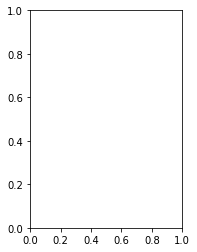

In [85]:
plt.subplot(1,2,1)
plt.plot(number_esti, roc_auc_score_RF, '.', label='function of n')
plt.plot(time_taken, roc_auc_score_RF, '.', label='function of time')
plt.legend()
plt.subplot(1,2,2)
plt.plot(number_esti, time_taken, '.')

### 2. Decision Tree

In [94]:
param_grid = {'min_impurity_decrease': [0], 
               'max_features': [3,4,5],
               'min_samples_leaf': [10,20,30],
               'min_weight_fraction_leaf': [0]}

DT_clf = DecisionTreeClassifier(random_state=42)
grid_search = GridSearchCV(DT_clf, param_grid, cv=3)

grid_search.fit(x_train, y_train_galaxy)

grid_search.best_params_

{'max_features': 5,
 'min_impurity_decrease': 0,
 'min_samples_leaf': 20,
 'min_weight_fraction_leaf': 0}

### 3. KNN

In [109]:
param_grid = {'n_neighbors': [4],
               'p': [1],
               'leaf_size': [1,2,3,4,5,6,7,8,9,10]}

neigh = KNeighborsClassifier()
grid_search = GridSearchCV(neigh, param_grid, cv=3)

grid_search.fit(x_train, y_train_galaxy)

grid_search.best_params_

{'leaf_size': 1, 'n_neighbors': 4, 'p': 1}

## Testing models on test set


In [86]:
# selected parameters off fine tuning above
forest_clf = RandomForestClassifier(n_estimators=100, min_samples_split=70, min_samples_leaf=20,
                                    min_weight_fraction_leaf=0, max_features=3, random_state=42)
forest_clf.fit(x_train, y_train_galaxy)
y_test_pred = forest_clf.predict(x_test)

print("FOR THE RANDOM FOREST CLASSIFIER\n")
print(confusion_matrix(y_test_galaxy, y_test_pred))
print("F1 score of the model", f1_score(y_test_galaxy, y_test_pred))

FOR THE RANDOM FOREST CLASSIFIER

[[ 4328   246]
 [  135 10001]]
F1 score of the model 0.9813079527056862


In [135]:
# selected parameters off fine tuning above
DT_clf = DecisionTreeClassifier(max_features=5, min_impurity_decrease=0,min_samples_leaf=20,
                                min_weight_fraction_leaf=0, random_state=42)
DT_clf.fit(x_train, y_train_galaxy)
y_test_pred = DT_clf.predict(x_test)

print("FOR THE DECISION TREE CLASSIFIER\n")
print(confusion_matrix(y_test_galaxy, y_test_pred))
print("F1 score of the model", f1_score(y_test_galaxy, y_test_pred))

FOR THE DECISION TREE CLASSIFIER

[[4316  258]
 [ 190 9946]]
F1 score of the model 0.9779744346116028


In [119]:
# selected parameters off fine tuning above
neigh = KNeighborsClassifier(n_neighbors=4,leaf_size=1, p=1)
neigh.fit(x_train, y_train_galaxy)
y_test_pred = neigh.predict(x_test)

print("FOR THE KNN CLASSIFIER\n")
print(confusion_matrix(y_test_galaxy, y_test_pred))
print("F1 score of the model", f1_score(y_test_galaxy, y_test_pred))

FOR THE KNN CLASSIFIER

[[4196  378]
 [ 401 9735]]
F1 score of the model 0.9615289643933033


### Detecting outliers where all models find false positives and false negatives

IDEA: COULD CHECK THE FALSE POSITIVE AND FALSE NEGATIVE BETWEEN THE DIFFERENT MODELS TO SEE IF THEY COINCIDE + MAYBE DO SOMETHING ABOUT THEM -> OUTLIERS WE COULD IGNORE FOR REGRESSION???

In [141]:
# Decision tree training set predictions
DT_clf = RandomForestClassifier(max_features=5, min_impurity_decrease=0,min_samples_leaf=20,
                                min_weight_fraction_leaf=0, random_state=42)
y_train_pred_DT = cross_val_predict(DT_clf,x_train,y_train_galaxy,cv=3)

In [142]:
# Random Forest training set predictions
RF_clf = RandomForestClassifier(n_estimators=100, min_samples_split=70, min_samples_leaf=20,
                                min_weight_fraction_leaf=0, max_features=3, random_state=42)
y_train_pred_RF = cross_val_predict(RF_clf,x_train,y_train_galaxy,cv=3)

In [143]:
# K-Nearest Neighbors training set predictions
KNN_clf = KNeighborsClassifier(n_neighbors=4,leaf_size=1, p=1)
y_train_pred_KNN = cross_val_predict(KNN_clf,x_train,y_train_galaxy,cv=3)

In [182]:
FN_pred_outliers_indices = []
FP_pred_outliers_indices = []

for n in range(0,len(x_train)):
    if y_train[n] == 'GALAXY':
        if y_train_pred_KNN[n] == y_train_pred_RF[n] == y_train_pred_DT[n] == False:
            FN_pred_outliers_indices = np.append(n, FN_pred_outliers_indices)
        else:
            pass
    else:
        if y_train_pred_KNN[n] == y_train_pred_RF[n] == y_train_pred_DT[n] == True:
            FP_pred_outliers_indices = np.append(n, FP_pred_outliers_indices)
        else:
            pass

array([58920., 58891., 58495., 58357., 58185., 57741., 57551., 57425.,
       57101., 57067., 56742., 56224., 56003., 55378., 55227., 55118.,
       54807., 54805., 54533., 54460., 54451., 54439., 53785., 53683.,
       53402., 53265., 53012., 52808., 52700., 52514., 51919., 51873.,
       51855., 51768., 51588., 51393., 51383., 51356., 51172., 50916.,
       50856., 50772., 50753., 50700., 50616., 50561., 50104., 49567.,
       49304., 49276., 49270., 49220., 49076., 49018., 48882., 48792.,
       48651., 48627., 48449., 48333., 48284., 48129., 48050., 47805.,
       47360., 47311., 47307., 47215., 47202., 46747., 46699., 46582.,
       46522., 46518., 46142., 46128., 45865., 45716., 45663., 45587.,
       45390., 45121., 45007., 44623., 44239., 44234., 44037., 44015.,
       43857., 43712., 43514., 43228., 42970., 42955., 42650., 42626.,
       42523., 42357., 42221., 42200., 42083., 41977., 41938., 41650.,
       41597., 41432., 41396., 41185., 41147., 41104., 40913., 40667.,
      